In [1]:
import torch
import numpy as np
import sys
import time
sys.path.append('../')
from channel_inference import FNO2d, SpectralConv2d
#from channel_transformer_inference import FNO2d,SpectralConv2d,SpectralAttention,ComplexSoftmax
import matplotlib.pyplot as plt

#model_path = "/home/iyer.ris/pipe/chtFNOphysics_65"
model_path="/home/iyer.ris/pipe/chtFNO_65"
# Initialize the model with the same parameters
#model = FNO2d(modes1, modes2, width)
with torch.no_grad():
    model = torch.load(model_path).to('cuda')


CUDA is available!


FNO2d(
  (fc0): Linear(in_features=5, out_features=128, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (conv4): SpectralConv2d()
  (w0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc_u1): Linear(in_features=128, out_features=64, bias=True)
  (fc_v1): Linear(in_features=128, out_features=64, bias=True)
  (fc_p1): Linear(in_features=128, out_features=64, bias=True)
  (fc_T1): Linear(in_features=128, out_features=64, bias=True)
  (fc_u2): Linear(in_features=64, out_features=1, bias=True)
  (fc_v2): Linear(in_features=64, out_features=1, bias=True)
  (fc_p2): Linear(in_features=64, out_features=1, bias=Tr

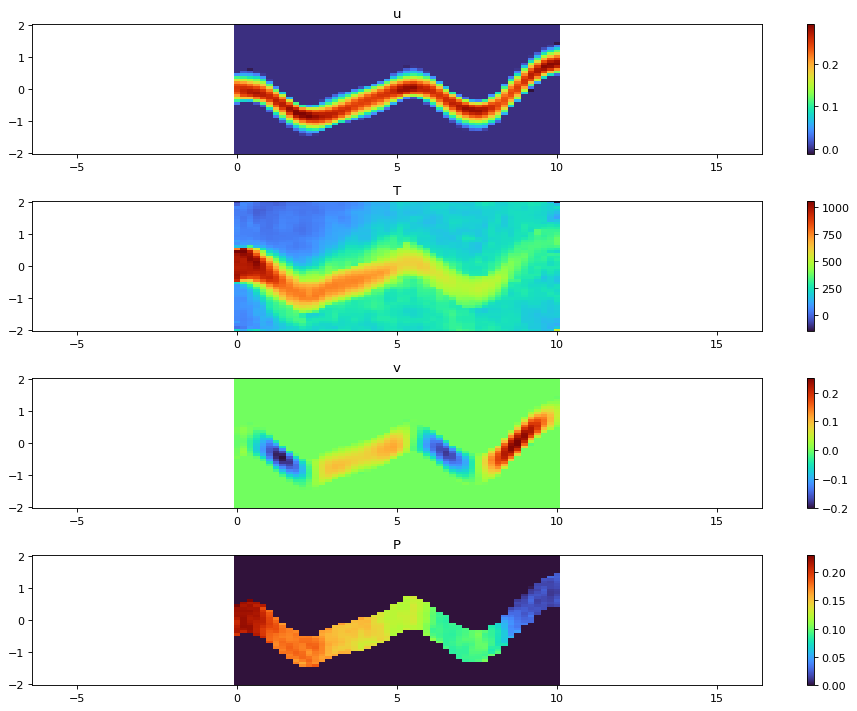

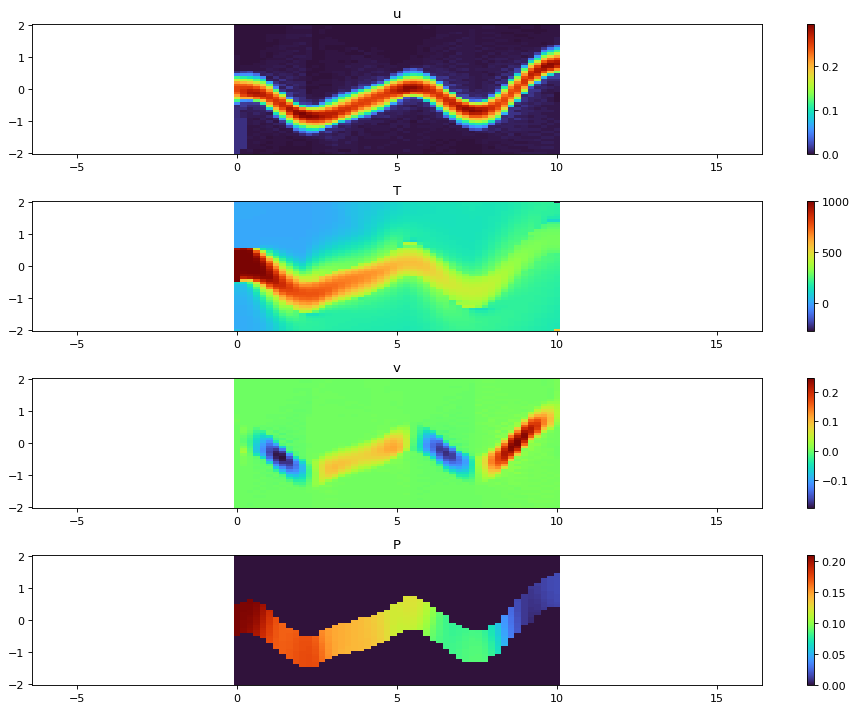

In [5]:
print(model)
# Set the same values of modes1 and modes2 in the model
model.eval()

# Constants
num_points = 100  # number of grid points
diameter = 1.0  # pipe diameter
radius = diameter / 2.0  # pipe radius

# Generate evenly spaced points in the Y dimension
y_values = np.linspace(-radius, radius, num_points)

# Repeat these points in the X dimension
Y_data1 = np.tile(y_values, (num_points, 1))
Y_data1 = np.repeat(Y_data1[np.newaxis, :, :], 2310, axis=0)

# Load X data
X_data = np.load("/home/iyer.ris/xgrid_store.npy")[45]
Y_data=np.load("/home/iyer.ris/ygrid_store.npy")[45]
Mask_data=np.load('/home/iyer.ris/mask_store.npy')[45]
# Prepare input data for model
input_X = torch.tensor(X_data, dtype=torch.float)
#print(input_X.shape)
input_Y = torch.tensor(Y_data, dtype=torch.float)
mask=torch.tensor(Mask_data,dtype=torch.float)
# Concatenate X and Y along the last dimension
input_data = torch.stack([input_X, input_Y,mask], dim=-1)
#print(input_data.shape)
input_data = input_data.unsqueeze(0).to('cuda')
#print(input_data.shape)

# Downsample
#input_data = input_data[:, ::r1, ::r2][:, :s1, :s2]

# Perform inference
start=time.time()
u,v,P,T = model(input_data.to('cuda'))  # If using GPU
end=time.time()
print('time to complete',end-start,'s')


#print(output)
# Now output holds the result of the forward pass
#print(output)

# Print the shape of prediction
print(u.shape)

print(input_X.shape,input_Y.shape,u.shape)
print(u.size(1))
ux_cpu=u.squeeze()
ux_cpu = ux_cpu[:,:].cpu().detach().numpy()

v=v.squeeze()
v=v[:,:].cpu().detach().numpy()
P=P.squeeze()
P=P[:,:].cpu().detach().numpy()
T=T.squeeze()
T=T[:,:].cpu().detach().numpy()
mask=mask[:,:].cpu().detach().numpy()
ux_cpu = np.where(mask == 0, 0, ux_cpu)
v = np.where(mask == 0, 0, v)
P = np.where(mask == 0, 0, P)
fig, ax = plt.subplots(4, 1, figsize=(12, 9), dpi=80)
im0 = ax[0].pcolormesh(input_X, input_Y, ux_cpu, cmap='turbo')
fig.colorbar(im0, ax = ax[0])
ax[0].set_title("u")
ax[0].axis('equal')
print(ux_cpu)
im2=ax[2].pcolormesh(input_X, input_Y, v, cmap='turbo')
fig.colorbar(im2, ax = ax[2])
ax[2].set_title("v")
ax[2].axis('equal')
fig.tight_layout()
fig.show()
im3=ax[3].pcolormesh(input_X, input_Y, P, cmap='turbo')
fig.colorbar(im3, ax = ax[3])
ax[3].set_title("P")
ax[3].axis('equal')
fig.tight_layout()
fig.show()

im1 = ax[1].pcolormesh(input_X, input_Y, T, cmap='turbo')
fig.colorbar(im1, ax = ax[1])
ax[1].set_title("T")
ax[1].axis('equal')
fig.tight_layout()
fig.show()
##ground truth
u_ground=np.load("/home/iyer.ris/u_store.npy")[45]
v_ground=np.load("/home/iyer.ris/v_store.npy")[45]
T_ground=np.load("/home/iyer.ris/T_store.npy")[45]
p_ground=np.load("/home/iyer.ris/p_store.npy")[45]
p_ground= np.where(mask == 0, 0, p_ground)
fig, ax = plt.subplots(4, 1, figsize=(12, 9), dpi=80)
im0 = ax[0].pcolormesh(input_X, input_Y, u_ground, cmap='turbo')
fig.colorbar(im0, ax = ax[0])
ax[0].set_title("u")
ax[0].axis('equal')
print(ux_cpu)
im2=ax[2].pcolormesh(input_X, input_Y, v_ground, cmap='turbo')
fig.colorbar(im2, ax = ax[2])
ax[2].set_title("v")
ax[2].axis('equal')
fig.tight_layout()
fig.show()

im1 = ax[1].pcolormesh(input_X, input_Y, T_ground, cmap='turbo')
fig.colorbar(im1, ax = ax[1])
ax[1].set_title("T")
ax[1].axis('equal')
fig.tight_layout()
fig.show()
im3=ax[3].pcolormesh(input_X,input_Y,p_ground,cmap='turbo')
fig.colorbar(im3, ax = ax[3])
ax[3].set_title("P")
ax[3].axis('equal')
fig.tight_layout()
fig.show()

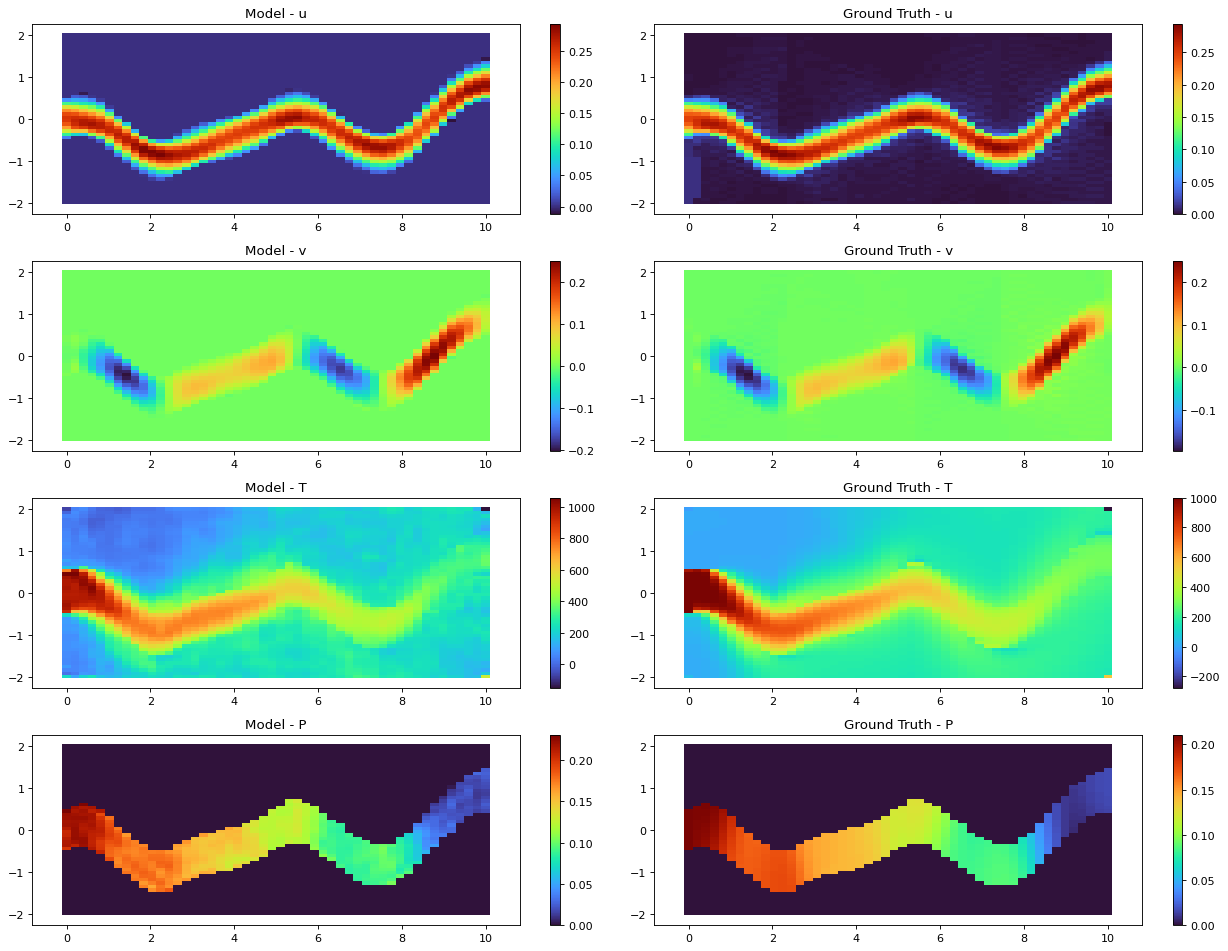

0.0019252490205555418


In [6]:
fig, ax = plt.subplots(4, 2, figsize=(16, 12), dpi=80)

# Model plots
im0 = ax[0, 0].pcolormesh(input_X, input_Y, ux_cpu, cmap='turbo')
fig.colorbar(im0, ax=ax[0, 0])
ax[0, 0].set_title("Model - u")
ax[0, 0].axis('equal')

im2 = ax[1, 0].pcolormesh(input_X, input_Y, v, cmap='turbo')
fig.colorbar(im2, ax=ax[1, 0])
ax[1, 0].set_title("Model - v")
ax[1, 0].axis('equal')

im1 = ax[2, 0].pcolormesh(input_X, input_Y, T, cmap='turbo')
fig.colorbar(im1, ax=ax[2, 0])
ax[2, 0].set_title("Model - T")
ax[2, 0].axis('equal')

im3 = ax[3, 0].pcolormesh(input_X, input_Y, P, cmap='turbo')
fig.colorbar(im3, ax=ax[3, 0])
ax[3, 0].set_title("Model - P")
ax[3, 0].axis('equal')

# Ground truth plots
im4 = ax[0, 1].pcolormesh(input_X, input_Y, u_ground, cmap='turbo')
fig.colorbar(im4, ax=ax[0, 1])
ax[0, 1].set_title("Ground Truth - u")
ax[0, 1].axis('equal')

im5 = ax[1, 1].pcolormesh(input_X, input_Y, v_ground, cmap='turbo')
fig.colorbar(im5, ax=ax[1, 1])
ax[1, 1].set_title("Ground Truth - v")
ax[1, 1].axis('equal')

im6 = ax[2, 1].pcolormesh(input_X, input_Y, T_ground, cmap='turbo')
fig.colorbar(im6, ax=ax[2, 1])
ax[2, 1].set_title("Ground Truth - T")
ax[2, 1].axis('equal')

im7 = ax[3, 1].pcolormesh(input_X, input_Y, p_ground, cmap='turbo')
fig.colorbar(im7, ax=ax[3, 1])
ax[3, 1].set_title("Ground Truth - P")
ax[3, 1].axis('equal')

fig.tight_layout()
plt.show()
diff = np.where(mask == 0, 0, np.abs((p_ground-P)))
acc=np.mean(diff)
print(acc)

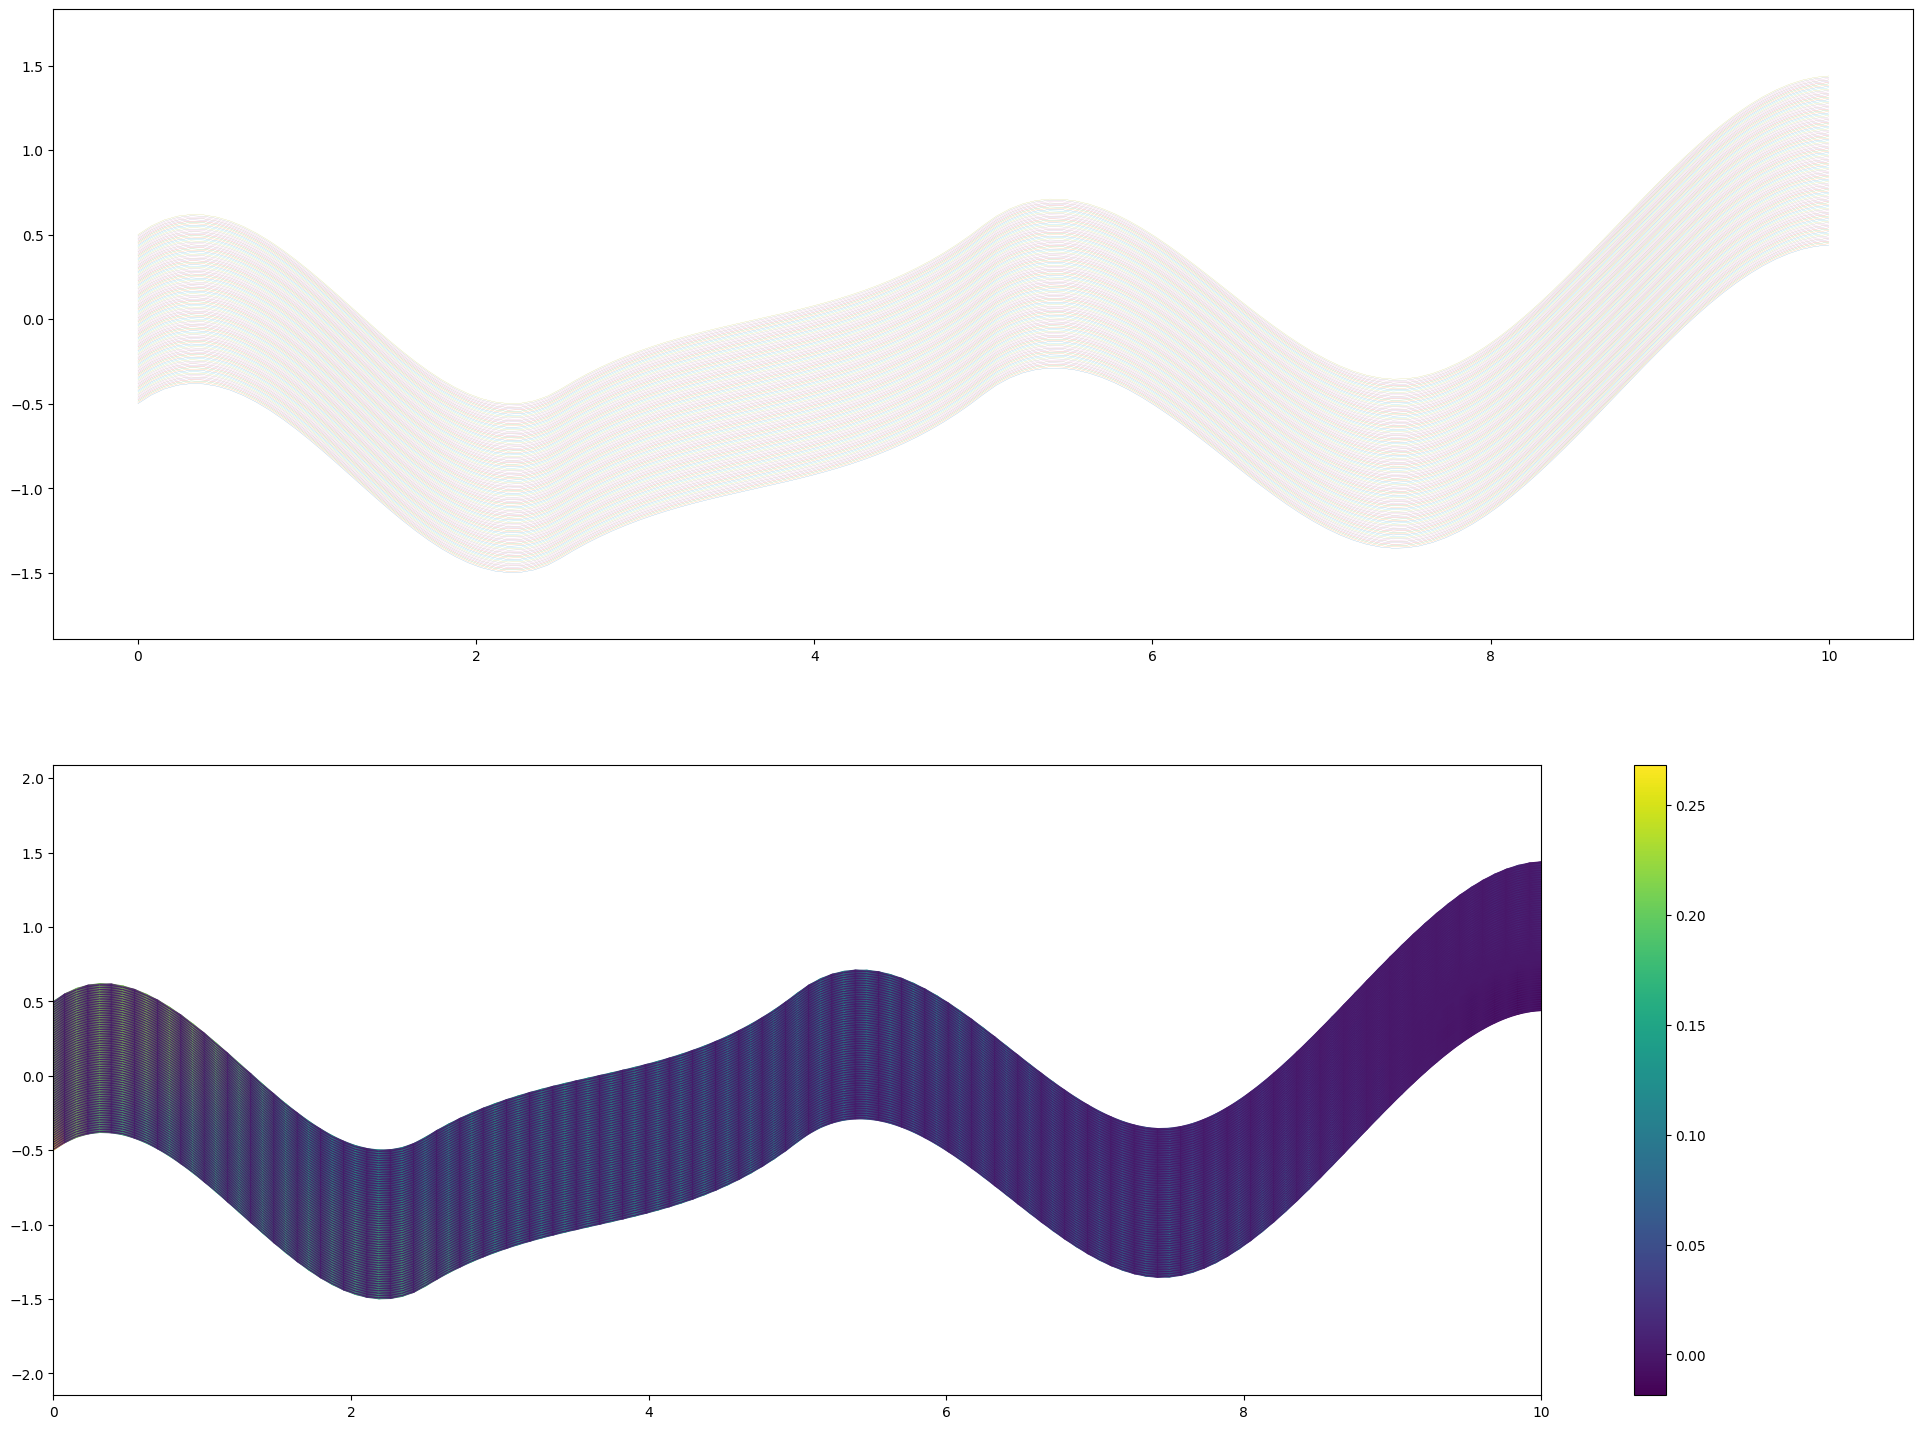